<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [48]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [49]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [1]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

KeyboardInterrupt: ignored

In [ ]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [52]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


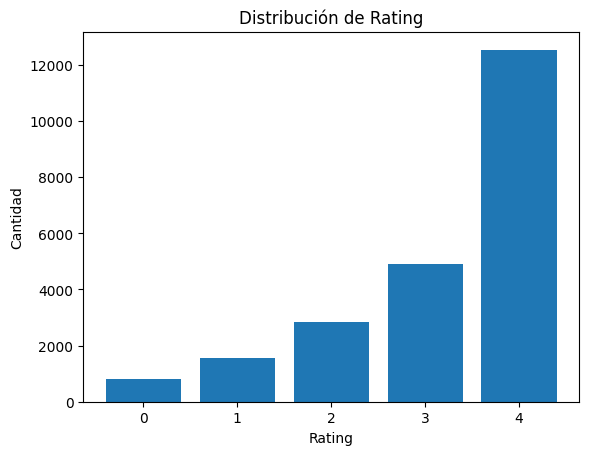

In [53]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

# Calcular la frecuencia de cada categoría de Rating
rating_counts = df_reviews['Rating'].value_counts().sort_index()

# Crear el gráfico de barras
plt.bar(rating_counts.index, rating_counts.values)

# Agregar etiquetas y título
plt.xlabel('Rating')
plt.ylabel('Cantidad')
plt.title('Distribución de Rating')

# Mostrar el gráfico
plt.show()

Se puede ver que se encuentra muuy desbalanceado el dataset.

In [54]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

# Extraer la columna "Review" y convertirla en un vector NumPy
reviews_np = np.array(df_reviews['Review Text'])

In [55]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
num_reviews = len(reviews_np)
print("Número de revisiones (filas):", num_reviews)

Número de revisiones (filas): 22641


In [56]:
# Alumno: Concatenar todas las reviews para armar el corpus

def get_list(series):
    reviews_list = series.tolist()
    reviews_list = [str(text) if not pd.isnull(text) else "" for text in reviews_list]
    return reviews_list

def concat_all(series):
  reviews_list = get_list(series)
  all_reviews_one_string = ' '.join(reviews_list)
  return all_reviews_one_string

In [57]:
# Alumno: ¿Cuál es la longitud de ese corpus?
longitud_corpus = len(corpus)

print("Longitud del corpus:", longitud_corpus)

Longitud del corpus: 7011643


In [58]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

tokens = text_to_word_sequence(corpus)

In [59]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
print(tokens[:20])

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']


In [60]:
# Alumno: ¿Cuántos tokens/palabras hay?
numero_de_tokens = len(tokens)

print("Número de tokens/palabras:", numero_de_tokens)

Número de tokens/palabras: 1372203


In [61]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words

reviews_list = get_list(reviews_np)

# Inicializar el tokenizador
tokenizer = Tokenizer(num_words=num_words)

# Ajustar el tokenizador al corpus
tokenizer.fit_on_texts(reviews_list)

# Convertir palabras a secuencias de números enteros
secuencias_enteros = tokenizer.texts_to_sequences(reviews_list)



In [62]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

# Alumno: Convertir las palabras/tokens a números

# Obtener el diccionario de palabra a índice
word_index = tokenizer.word_index

# Obtener la cantidad total de vocabulario
vocabulario_total = len(word_index)

print("Diccionario palabra a índice:")
print(word_index)
print("\nCantidad total de vocabulario:", vocabulario_total)

Diccionario palabra a índice:
{'the': 1, 'i': 2, 'and': 3, 'a': 4, 'it': 5, 'is': 6, 'this': 7, 'to': 8, 'in': 9, 'but': 10, 'on': 11, 'for': 12, 'of': 13, 'with': 14, 'was': 15, 'so': 16, 'my': 17, 'dress': 18, 'not': 19, 'that': 20, 'love': 21, 'size': 22, 'very': 23, 'have': 24, 'top': 25, 'fit': 26, 'are': 27, 'like': 28, 'be': 29, 'as': 30, 'me': 31, 'wear': 32, "it's": 33, 'great': 34, 'too': 35, "i'm": 36, 'or': 37, 'am': 38, 'just': 39, 'you': 40, 'would': 41, 'they': 42, 'up': 43, 'at': 44, 'fabric': 45, 'small': 46, 'color': 47, 'look': 48, 'if': 49, 'more': 50, 'really': 51, 'ordered': 52, 'little': 53, 'perfect': 54, 'will': 55, 'one': 56, 'these': 57, 'flattering': 58, 'well': 59, 'an': 60, 'soft': 61, 'out': 62, 'back': 63, 'because': 64, 'had': 65, 'can': 66, '\r': 67, 'comfortable': 68, 'cute': 69, 'nice': 70, 'than': 71, 'bought': 72, 'beautiful': 73, 'when': 74, 'all': 75, 'looks': 76, 'bit': 77, 'fits': 78, 'large': 79, 'shirt': 80, 'down': 81, 'which': 82, 'material

In [63]:
# Alumno: Determinar cual es la oración más larga
revision_mas_larga = ""
longitud_mas_larga = 0

# Itera a través de las filas del DataFrame
for index, row in df_reviews.iterrows():
    revision = row['Review Text']
    palabras = revision.split()  # Divide la revisión en palabras
    longitud_actual = len(palabras)

    # Comprueba si la longitud de la revisión actual es mayor que la longitud de la más larga hasta ahora
    if longitud_actual > longitud_mas_larga:
        longitud_mas_larga = longitud_actual
        revision_mas_larga = revision

# Imprime la revisión más larga y su longitud
print("Revisión más larga:")
print(revision_mas_larga)
print("\nLongitud de la revisión más larga en palabras:", longitud_mas_larga)

Revisión más larga:
I love shift dresses and i love t linen so this one was a must for me. i had it in my inbox as soon as it came out on the website and then i found it in the store and had to try it on. i took the six and the eight to the fitting room because i run in between, and the six fit better so i guess it runs a little bit large. really it just depends on how you want it to fit. the length is great too, about 3 inches above my knee, i'm 5 foot 5, which is exactly where i like my dresses to hit. i got the

Longitud de la revisión más larga en palabras: 115


In [64]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
from keras.preprocessing.sequence import pad_sequences
maxlen = 115

longitud_maxima = max(len(seq) for seq in secuencias_enteros)

# Aplicar el relleno a todas las sentencias
secuencias_padeadas = pad_sequences(secuencias_enteros, maxlen=longitud_maxima, padding='post')

In [65]:
# Alumno: Observar las dimensiones de la variable input

dimensiones_input = secuencias_padeadas.shape

print("Dimensiones de la variable input:", dimensiones_input)

Dimensiones de la variable input: (22641, 115)


In [29]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

# Transformar la columna "Rating" en codificación one-hot
y = pd.get_dummies(df_reviews['Rating'], columns=['Rating'])

# Verificar la forma de y
print("Shape de y:", y.shape)

Shape de y: (22641, 5)


In [66]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

test_size = 0.2

# Realizar la división en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(secuencias_padeadas, y, test_size=test_size, random_state=42)

In [67]:
# Alumno: determinar la dimensiones de entrada y salida
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]
print(input_shape)
print(output_shape)

115
5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [68]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dropout, Dense


In [70]:
input_length = 115
embedding_dim = 1000
# Crear un modelo Sequential
model = Sequential()

# Agregar una capa de Embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))

# Agregar una capa LSTM
model.add(LSTM(units=128, activation='relu'))  # Puedes ajustar los hiperparámetros según sea necesario

# Agregar una capa de Dropout para regularización
model.add(Dropout(0.2))  # Puedes ajustar la tasa de dropout según sea necesario

# Agregar una capa densa de salida (asumiendo 5 clases en tu caso)
model.add(Dense(5, activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluar el modelo
score = model.evaluate(X_test, y_test, verbose=0)
print('Puntuación de prueba:', score[0])
print('Exactitud de prueba:', score[1])

Epoch 1/10
283/283 [==============================] - 68s 219ms/step - loss: 1.2693 - accuracy: 0.5512 - val_loss: 1.2129 - val_accuracy: 0.5619
Epoch 2/10
283/283 [==============================] - 40s 142ms/step - loss: 13201.7295 - accuracy: 0.4888 - val_loss: 1.2134 - val_accuracy: 0.5619
Epoch 3/10
283/283 [==============================] - 36s 129ms/step - loss: 1.4590 - accuracy: 0.5020 - val_loss: 1.2079 - val_accuracy: 0.5619
Epoch 4/10
283/283 [==============================] - 37s 129ms/step - loss: 10353.7236 - accuracy: 0.5434 - val_loss: 1.2135 - val_accuracy: 0.5619
Epoch 5/10
283/283 [==============================] - 37s 130ms/step - loss: 1.2274 - accuracy: 0.5518 - val_loss: 1.2113 - val_accuracy: 0.5619
Epoch 6/10
283/283 [==============================] - 37s 131ms/step - loss: 1.2270 - accuracy: 0.5518 - val_loss: 1.2117 - val_accuracy: 0.5619
Epoch 7/10
283/283 [==============================] - 36s 126ms/step - loss: 1.2287 - accuracy: 0.5518 - val_loss: 1.2112 

Podemos ver que se obtiene una exactitud del 56%, esto puede que se deba al desbalance de las clases, y al tener un cierto sesgo al optar por esa clase, al ser tan grande la diferencia puede que termine acertando solo por el hecho del desbalance.